In [3]:
import matplotlib.pyplot as plt
import arviz
import matplotlib
import numpy
from datetime import timedelta as TimeDelta
import pymc
import random
from wf_reg_test.workflows2 import WorkflowApp2
import yaml
from pathlib import Path
import pandas
import pandas
random_seed = 0

# Data loading

In [4]:
wf_apps = yaml.load(Path("data.yaml").read_text(), Loader=yaml.UnsafeLoader)

In [5]:
def drop_keys(dct, drop_keys):
    return {
        key: val
        for key, val in dct.items()
        if key not in drop_keys
    }

def prefix_keys(dct, prefix_key):
    return {
        (prefix_key, key): val
        for key, val in dct.items()
    }

First I organize a Pandas dataframe

In [6]:
df = pandas.DataFrame.from_records(
    [
        {
            **prefix_keys(drop_keys(wf_app.__dict__, {"revisions"}), "wf_app"),
            **prefix_keys(drop_keys(revision.__dict__, {"executions", "workflow_app"}), "revision"),
            **prefix_keys(drop_keys(execution.__dict__, {"revisions"}), "execution"),
        }
        for wf_app_no, wf_app in enumerate(wf_apps)
        for revision in wf_app.revisions
        for execution in revision.executions
    ],
)
df.columns = pandas.MultiIndex.from_tuples(df.columns)
df["wf_app", "id"] = df["wf_app", "url"].astype("category").cat.codes
df["revision", "id"] = df["revision", "url"].astype("category").cat.codes
df["execution", "id"] = df.index
df["execution", "success"] = df["execution", "status_code"] == 0
df["execution", "total_cpu_time"] = df["execution", "system_cpu_time"] + df["execution", "user_cpu_time"]
df["execution", "staleness"] = (df["revision", "datetime"] - df["execution", "datetime"]) / numpy.timedelta64(1, 'Y')
df

wf_app                                                 \
        display_name                                       repo_url   
0        nf-core/mag       https://github.com/nf-core/mag?only_tags   
1        nf-core/mag       https://github.com/nf-core/mag?only_tags   
2        nf-core/mag       https://github.com/nf-core/mag?only_tags   
3        nf-core/mag       https://github.com/nf-core/mag?only_tags   
4        nf-core/mag       https://github.com/nf-core/mag?only_tags   
..               ...                                            ...   
77     nf-core/eager     https://github.com/nf-core/eager?only_tags   
78     nf-core/eager     https://github.com/nf-core/eager?only_tags   
79     nf-core/eager     https://github.com/nf-core/eager?only_tags   
80  nf-core/fetchngs  https://github.com/nf-core/fetchngs?only_tags   
81  nf-core/fetchngs  https://github.com/nf-core/fetchngs?only_tags   

                                                              revision  \
                          url workflow_engine_name            datetime   
0        https://nf-co.re/mag             nextflow 2019-12-21 10:19:32   
1        https://nf-co.re/mag             nextflow 2020-10-06 13:44:58   
2        https://nf-co.re/mag             nextflow 2020-11-10 17:11:59   
3        https://nf-co.re/mag             nextflow 2020-11-24 17:58:19   
4        https://nf-co.re/mag             nextflow 2020-11-24 17:58:19   
..                        ...                  ...                 ...   
77     https://nf-co.re/eager             nextflow 2019-03-06 07:12:31   
78     https://nf-co.re/eager             nextflow 2018-12-12 21:53:30   
79     https://nf-co.re/eager             nextflow 2018-11-02 13:39:17   
80  https://nf-co.re/fetchngs             nextflow 2022-07-01 16:09:31   
81  https://nf-co.re/fetchngs             nextflow 2021-11-09 15:26:35   

                                                                     \
   display_name  tree                                           url   
0         1.0.0  None     https://github.com/nf-core/mag/tree/1.0.0   
1         1.1.0  None     https://github.com/nf-core/mag/tree/1.1.0   
2         1.1.1  None     https://github.com/nf-core/mag/tree/1.1.1   
3         1.1.2  None     https://github.com/nf-core/mag/tree/1.1.2   
4         1.1.2  None     https://github.com/nf-core/mag/tree/1.1.2   
..          ...   ...                                           ...   
77        2.0.6  None   https://github.com/nf-core/eager/tree/2.0.6   
78        2.0.3  None   https://github.com/nf-core/eager/tree/2.0.3   
79        2.0.1  None   https://github.com/nf-core/eager/tree/2.0.1   
80          1.7  None  https://github.com/nf-core/fetchngs/tree/1.7   
81          1.4  None  https://github.com/nf-core/fetchngs/tree/1.4   

                    execution  \
                     datetime   
0  2022-09-14 10:43:26.856416   
1  2022-09-14 08:41:49.375005   
2  2022-09-14 08:16:47.746068   
3  2022-09-14 07:51:22.912981   
4  2022-09-28 08:43:22.019570   
..                        ...   
77 2022-09-29 11:09:45.752352   
78 2022-09-28 12:01:35.318244   
79 2022-09-30 20:10:36.485013   
80 2022-09-30 00:21:53.747077   
81 2022-09-29 04:33:17.542461   

                                                       ...              \
                                              machine  ... status_code   
0   Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           0   
1   Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           0   
2   Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           0   
3   Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           0   
4   Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           0   
..                                                ...  ...         ...   
77  Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           1   
78  Machine2 home-server-Linux-5.15.0-47-generic-x...  ...           1   
79  Machine2 home-server-Linux-5.

Then I throw out workflows with too few revisions.
Rather than mutate `df`, I will create a boolean mask.

In [7]:
min_number_of_revisions = 3
is_wf_id_plentiful = (
    df[[("wf_app", "id"), ("revision", "id")]]
    .drop_duplicates()
    .groupby(("wf_app", "id"))
    .aggregate(len)
    [("revision", "id")]
    > min_number_of_revisions
)
plentiful_wf_set = set(is_wf_id_plentiful[is_wf_id_plentiful].index)
plentiful_wf_mask = df[("wf_app", "id")].isin(plentiful_wf_set)
print(f"Throwing out workflows with fewer than {min_number_of_revisions}")
print(f"  {df[('wf_app', 'id')].nunique()} to {len(plentiful_wf_set)} workflows")
print(f"  {len(df)} to {sum(plentiful_wf_mask)} executions")

Throwing out workflows with fewer than 3
  12 to 7 workflows
  82 to 70 executions


In [8]:
_ten_colors = list(matplotlib.colormaps["tab10"].colors)
random.shuffle(_ten_colors)
def rand_color(idx, total):
    if total < 10:
        return _ten_colors[idx]
    else:
        raise NotImplementedError("Not implemented for more than 10 colors")

# Sanity checking the data

Let's see the runtime distributions.

Total CPU time is number of CPUs times the time the OS gave to this process. Walltime is the time on the clock on a wall that elapses.

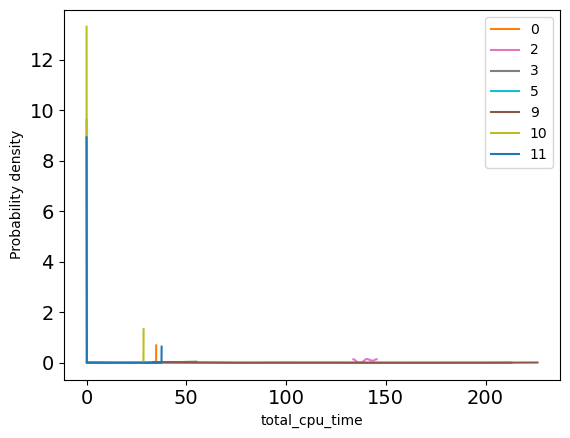

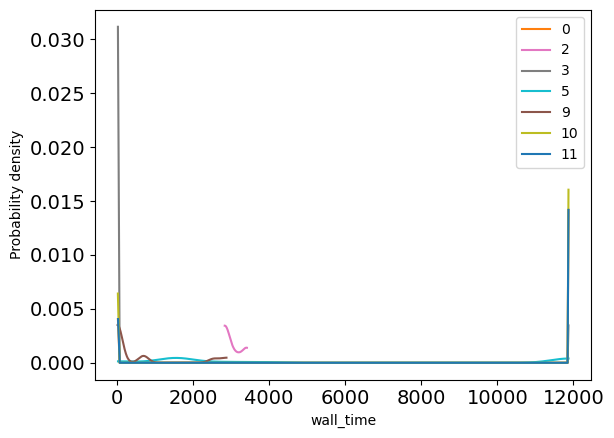

In [9]:
for time in ["total_cpu_time", "wall_time"]:
    fig = plt.figure()
    ax = fig.gca()
    times = numpy.linspace(0, 300, 100)
    for wf_id_no, wf_id in enumerate(plentiful_wf_set):
        arviz.plot_kde(
            df[df["wf_app", "id"] == wf_id]["execution", time].values.astype(int) / int(1e9),
            #values2=times,
            rug=False,
            ax=ax,
            plot_kwargs=dict(
                color=rand_color(wf_id_no, len(plentiful_wf_set)), 
            ),
            label=wf_id,
            legend=True,
        )
    ax.set_xlabel(time)
    ax.set_ylabel("Probability density")

Something's up with those executions that seem to take 0 wall time, for example, in wf_app 0.

In [10]:
df[df["wf_app", "id"] == 0][[("execution", "total_cpu_time"), ("execution", "output")]]

execution                       
           total_cpu_time                 output
45        0 days 00:00:00  data/f995923ec4cec79c
46        0 days 00:00:00  data/1377d15df987bdbb
47        0 days 00:00:00  data/60796c93107d5e53
48        0 days 00:00:00  data/acec83183a4a28ee
49        0 days 00:00:00  data/4ceb9fbd43cdd9ae
50 0 days 00:00:34.960000  data/52ace7197da8a2ff
51        0 days 00:00:00  data/27128fe6547b6af2
52        0 days 00:00:00  data/c10815c27df27eb0

This occurs when the process gets killed.

I will ignore these cases.

In [11]:
good_executions_mask = df["execution", "wall_time"] > numpy.timedelta64(100, "ms")
min_number_of_revisions = 3
is_wf_id_plentiful = (
    df[good_executions_mask]
    [[("wf_app", "id"), ("revision", "id")]]
    .drop_duplicates()
    .groupby(("wf_app", "id"))
    .aggregate(len)
    [("revision", "id")]
    > min_number_of_revisions
)
plentiful_wf_set = set(is_wf_id_plentiful[is_wf_id_plentiful].index)
plentiful_wf_mask = df[("wf_app", "id")].isin(plentiful_wf_set)
print(f"Throwing out workflows with fewer than {min_number_of_revisions}")
print(f"  {df[('wf_app', 'id')].nunique()} to {len(plentiful_wf_set)} workflows")
print(f"  {len(df)} to {sum(plentiful_wf_mask)} executions")

Throwing out workflows with fewer than 3
  12 to 7 workflows
  82 to 70 executions


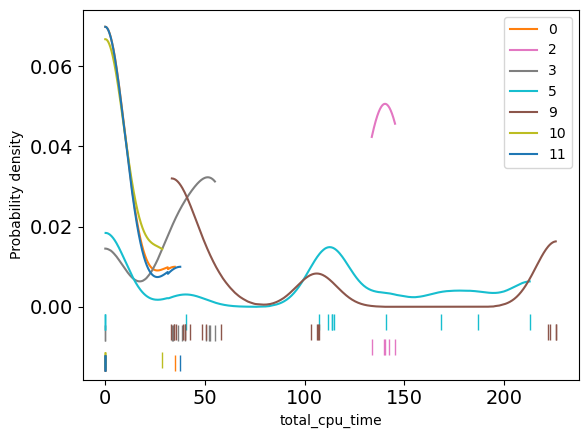

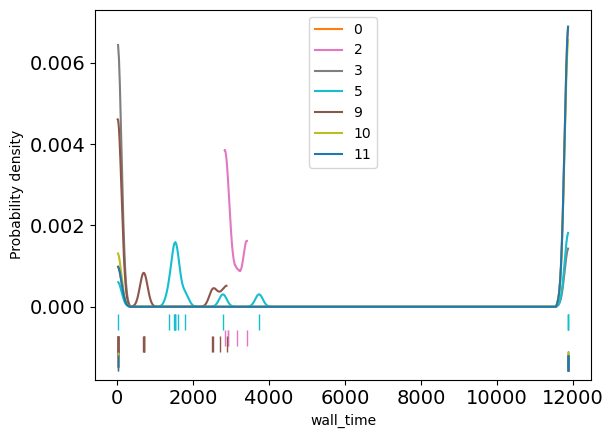

In [12]:
for time in ["total_cpu_time", "wall_time"]:
    fig = plt.figure()
    ax = fig.gca()
    times = numpy.linspace(0, 300, 100)
    for wf_id_no, wf_id in enumerate(plentiful_wf_set):
        arviz.plot_kde(
            df[plentiful_wf_mask][df[plentiful_wf_mask]["wf_app", "id"] == wf_id]["execution", time].values.astype(int) / int(1e9),
            bw={"total_cpu_time": 10, "wall_time": 100}[time],
            rug=True,
            ax=ax,
            plot_kwargs=dict(
                color=rand_color(wf_id_no, len(plentiful_wf_set)), 
            ),
            label=wf_id,
            legend=True,
        )
    ax.set_xlabel(time)
    ax.set_ylabel("Probability density")

That looks better.

Now to visualize the pass/fails over time.

In [13]:
def fix_axes(ax, title):
    ax.set_xlim(df["execution", "staleness"].min() * 1.1, 0)
    ax.set_xlabel("Years")
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_ylabel("works = 1, fails = 0")
    ax.set_title(title)

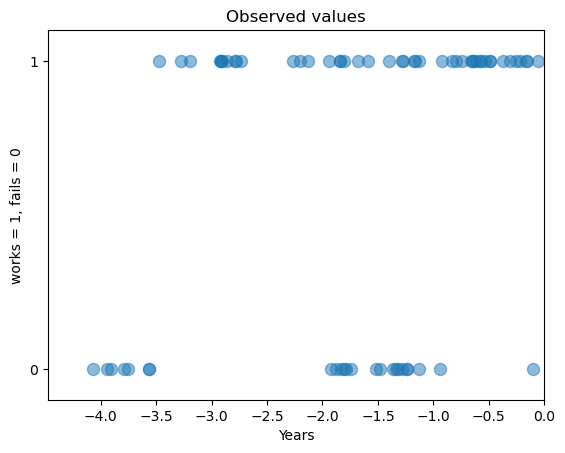

In [14]:
plt.scatter(
    df[plentiful_wf_mask]["execution", "staleness"],
    df[plentiful_wf_mask]["execution", "success"],
    s=75,
    alpha=1/2,
)
fix_axes(plt.gca(), title="Observed values")

# First Bayesian model

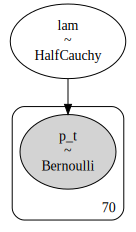

In [15]:
exp_decay_model = pymc.Model()
with exp_decay_model:
    lam = pymc.HalfCauchy("lam", beta=1/2)
    p_t = pymc.Bernoulli(
        "p_t",
        p=pymc.math.exp(lam * df[plentiful_wf_mask]["execution", "staleness"]),
        observed=df[plentiful_wf_mask]["execution", "success"],
    )
pymc.model_to_graphviz(exp_decay_model)

These are prior models that the MCMC chain will consider. They range from very little probability of failure at all at all, to near certain failures after just half a year.

Sampling: [lam, p_t]


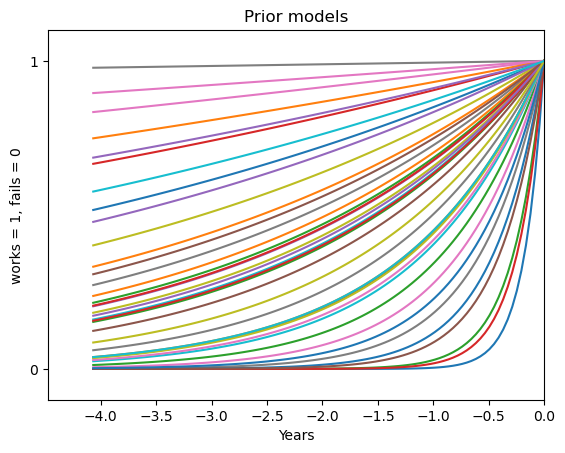

In [16]:
n_prior_samples = 40
with exp_decay_model:
    idata = pymc.sample_prior_predictive(samples=n_prior_samples, random_seed=random_seed)

n_times = 100
lin_times = numpy.linspace(df[plentiful_wf_mask]["execution", "staleness"].values.min(), 0, n_times)

y_rows = numpy.exp(numpy.tile(lin_times, (n_prior_samples, 1)) * idata.prior.lam.values.T)
for y_row in y_rows:
    plt.plot(lin_times, y_row)
fix_axes(plt.gca(), title="Prior models")

In [17]:
n_posterior_points = 3000
with exp_decay_model:
    idata = pymc.sample(n_posterior_points, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 5 seconds.


This is are some posterior models. Each model is a random draw from the distribution of possible models. The goal is not to hit all the points, but to find the most plausible coefficient of decay given these points.

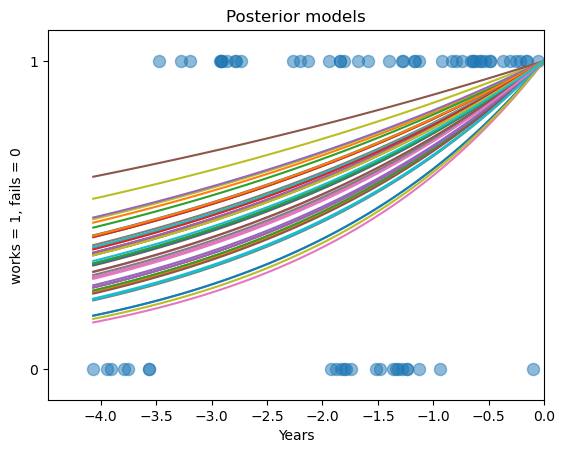

In [18]:
n_posterior_samples = 50
posterior_lam = idata.posterior.lam[1, -n_posterior_samples:].values[:, numpy.newaxis]
y_rows = numpy.exp(numpy.tile(lin_times, (n_posterior_samples, 1)) * posterior_lam)
for y_row in y_rows:
    plt.plot(lin_times, y_row)
plt.scatter(
    df[plentiful_wf_mask]["execution", "staleness"],
    df[plentiful_wf_mask]["execution", "success"],
    s=75,
    alpha=1/2,
)
fix_axes(plt.gca(), title="Posterior models")

In [19]:
one_lam = round(idata.posterior.lam.values[-1, -1], 3)
print(f"lambda = {one_lam:.3f}, so prob(year) = {numpy.exp(-0.399):.3f} * prob(previous year)")

lambda = 0.258, so prob(year) = 0.671 * prob(previous year)


In [ ]:
with exp_decay_model:
    test_period = numpy.linspace(0.1, 6, 100)
    pymc.math.exp(lam * -test_period)

# Unpooled

Now, I will try an unpooled model. That is, all workflows have a global distribution from which they draw a decay parameter, but different workflows have different decay parameters. This is because some workflows are more stable than others.

In [20]:
wf_id_map = dict(enumerate(sorted(list(plentiful_wf_set))))
wf_id_map_reverse = dict(map(lambda x: x[::-1], wf_id_map.items()))

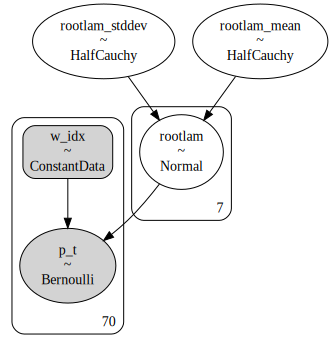

In [21]:
unpooled_exp_decay_model = pymc.Model()
with unpooled_exp_decay_model:
    wf_ids = list(map(wf_id_map_reverse.get, df[plentiful_wf_mask]["wf_app", "id"].values))
    w_idx = pymc.ConstantData("w_idx", wf_ids)
    rootlam_mean = pymc.HalfCauchy("rootlam_mean", beta=1/20)
    rootlam_stddev = pymc.HalfCauchy("rootlam_stddev", beta=1/2)
    rootlam = pymc.Normal("rootlam", rootlam_mean, rootlam_stddev, shape=len(wf_id_map))
    lam = rootlam**2
    p_t = pymc.Bernoulli(
        "p_t",
        p=pymc.math.exp(lam[w_idx] * df[plentiful_wf_mask]["execution", "staleness"].values),
        observed=df[plentiful_wf_mask]["execution", "success"].values,
    )
pymc.model_to_graphviz(unpooled_exp_decay_model)

Let's view the priors again

In [22]:
with unpooled_exp_decay_model:
    idata = pymc.sample_prior_predictive(samples=n_prior_samples, random_seed=random_seed)

Sampling: [p_t, rootlam, rootlam_mean, rootlam_stddev]


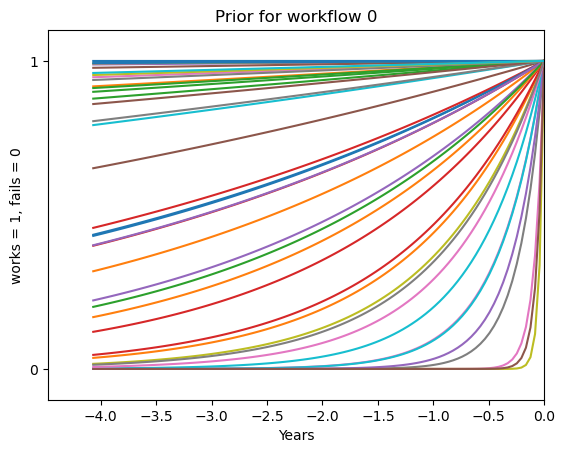

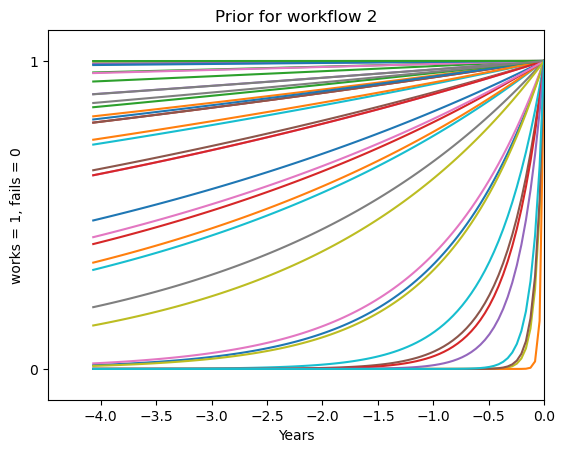

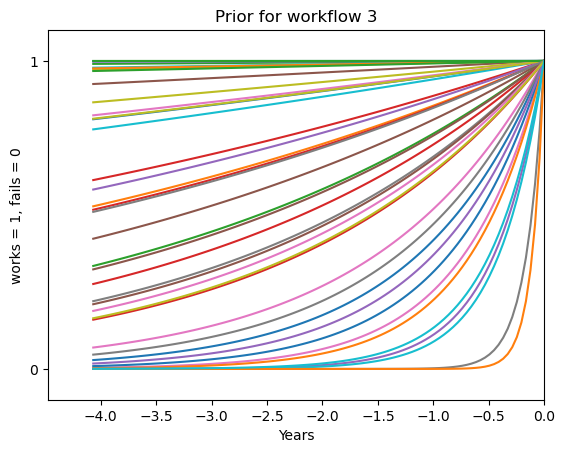

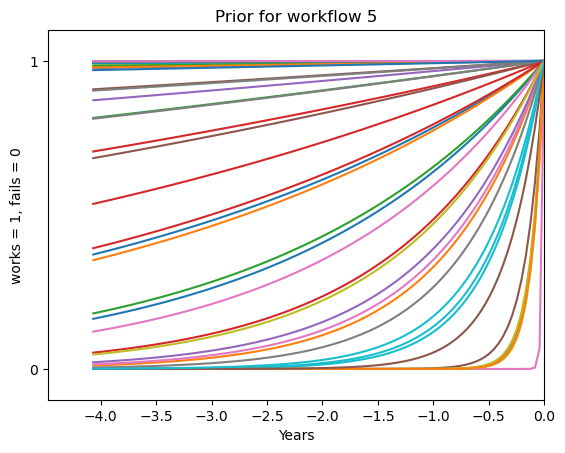

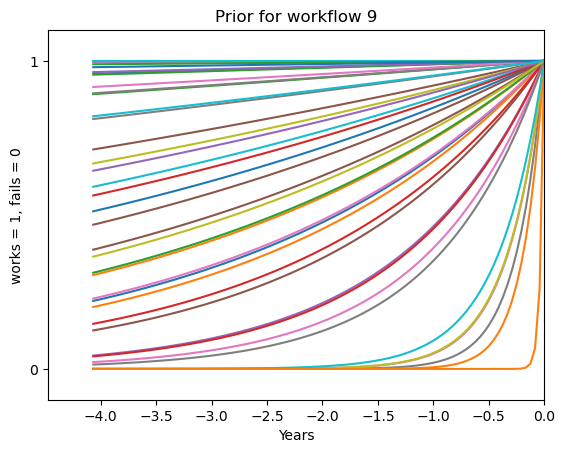

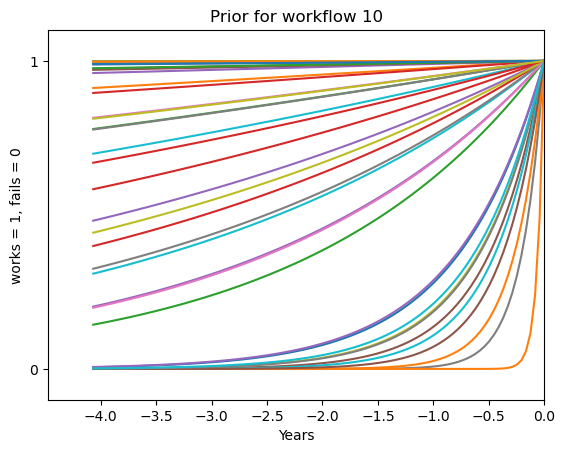

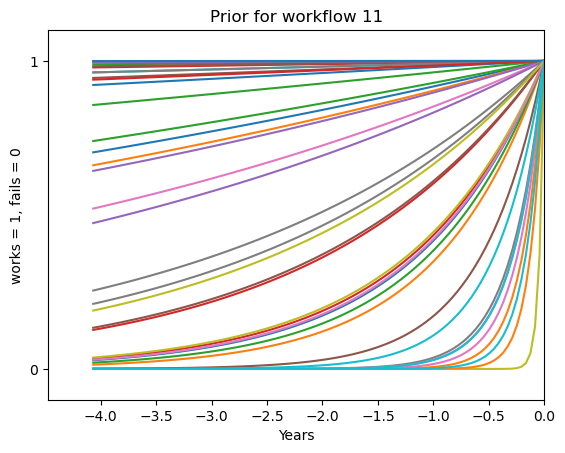

In [23]:
for mcmc_wf_id, wf_id in wf_id_map.items():
    rootlam = idata.prior.rootlam.values.T[mcmc_wf_id]
    y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
    fig = plt.figure()
    ax = fig.gca()
    for y_row in y_rows:
        ax.plot(lin_times, y_row)
    fix_axes(ax, f"Prior for workflow {wf_id}")
    

In [24]:
with unpooled_exp_decay_model:
    idata = pymc.sample(n_posterior_points, random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rootlam_mean, rootlam_stddev, rootlam]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 14 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6709, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


Here is the fitted model. Note there is a different distribution of models for each workflow and one for the whole population.

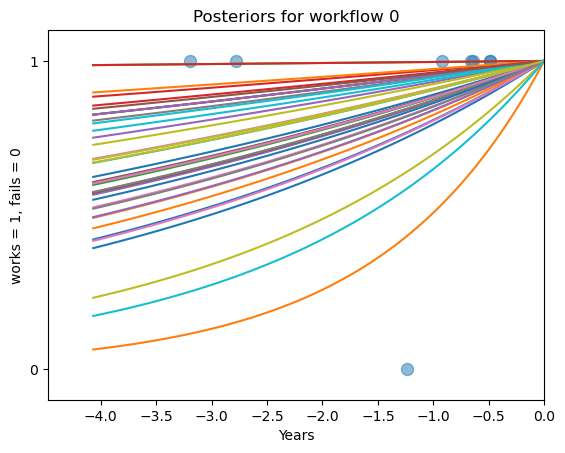

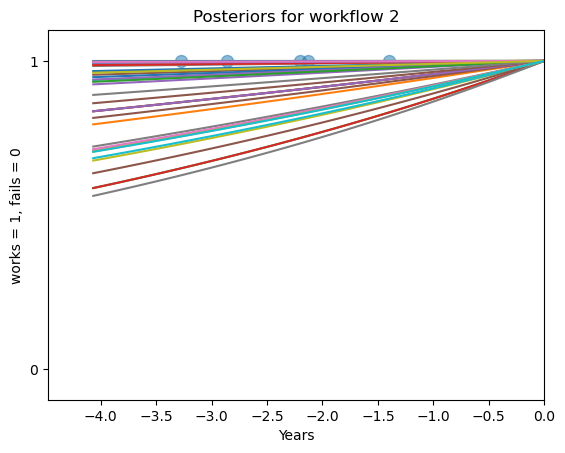

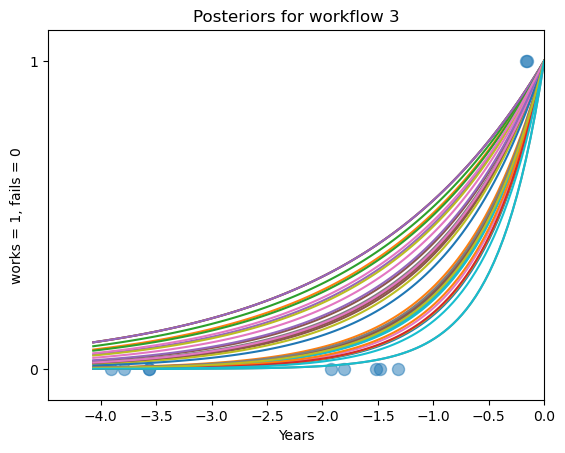

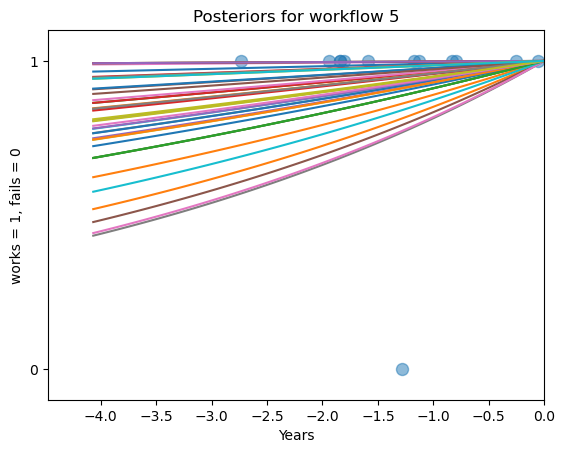

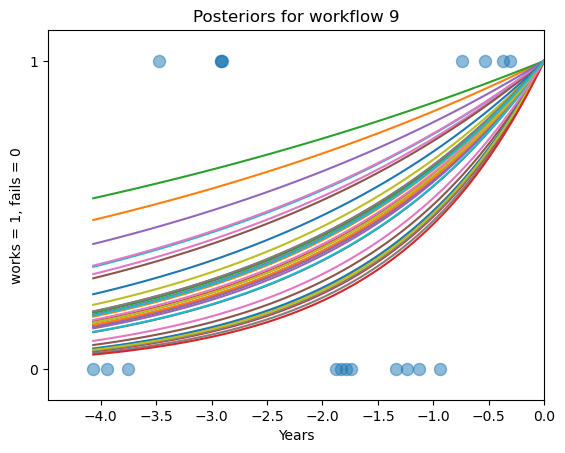

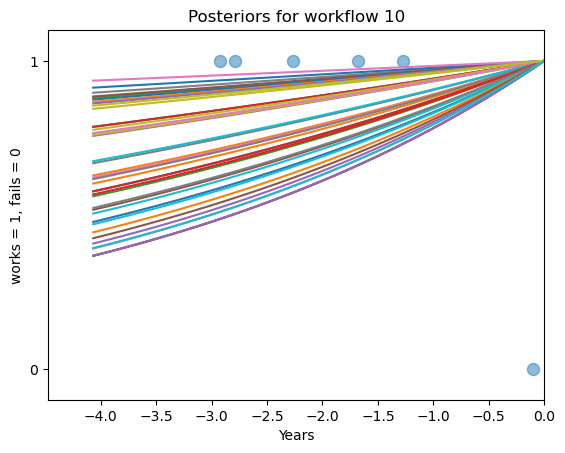

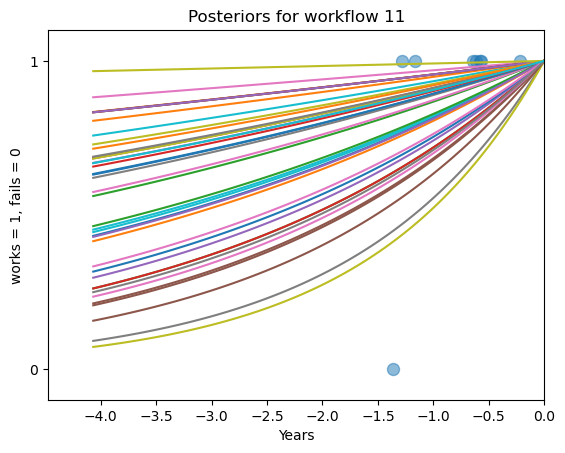

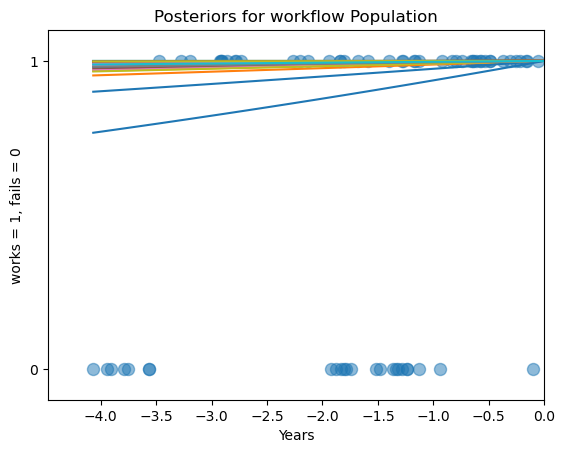

In [25]:
for mcmc_wf_id, wf_id in wf_id_map.items():
    rootlam = idata.posterior.rootlam[-1:, -n_prior_samples:, mcmc_wf_id].T
    y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
    fig = plt.figure()
    ax = fig.gca()
    for y_row in y_rows:
        ax.plot(lin_times, y_row)
    ax.scatter(
        df[plentiful_wf_mask][df[plentiful_wf_mask]["wf_app", "id"] == wf_id]["execution", "staleness"],
        df[plentiful_wf_mask][df[plentiful_wf_mask]["wf_app", "id"] == wf_id]["execution", "success"],
        s=75,
        alpha=1/2,
    )
    fix_axes(ax, f"Posteriors for workflow {wf_id}")

rootlam = idata.posterior.rootlam_mean[-1:, -n_prior_samples:].T
y_rows = numpy.exp(rootlam**2 * lin_times[numpy.newaxis, :])
fig = plt.figure()
ax = fig.gca()
for y_row in y_rows:
    ax.plot(lin_times, y_row)
ax.scatter(
    df[plentiful_wf_mask]["execution", "staleness"],
    df[plentiful_wf_mask]["execution", "success"],
    s=75,
    alpha=1/2,
)
fix_axes(ax, f"Posteriors for workflow Population")

Here is a distribution of the decay parameter.

I have to render the population on a different graph because it would dwarf the scale.

(1.0, 3.0)

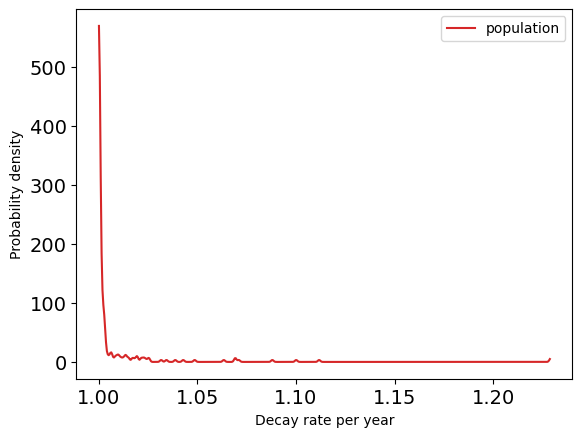

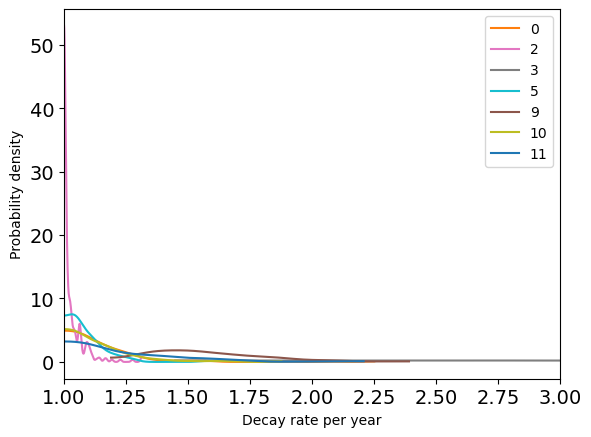

In [26]:
fig = plt.figure()
ax = fig.gca()
arviz.plot_kde(
    numpy.exp(idata.posterior.rootlam_mean[-1, :200].values**2),
    rug=False,
    ax=ax,
    plot_kwargs=dict(
        color=rand_color(len(plentiful_wf_set), len(plentiful_wf_set) + 1), 
    ),
    label="population",
    legend=True,
)
ax.set_xlabel("Decay rate per year")
ax.set_ylabel("Probability density")

fig = plt.figure()
ax = fig.gca()
for mcmc_wf_id, wf_id in wf_id_map.items():
    arviz.plot_kde(
        values=numpy.exp(idata.posterior.rootlam[-1, :200, mcmc_wf_id].values**2),
        ax=ax,
        plot_kwargs=dict(
            color=rand_color(mcmc_wf_id, len(plentiful_wf_set) + 1), 
        ),
        label=wf_id,
        #legend=False,
        #quantiles=[0.25, 0.5, 0.75],
    )
ax.set_xlabel("Decay rate per year")
ax.set_ylabel("Probability density")
ax.set_xlim(1.0, 3)